# Time constant effects for learning in time
In this notebook I intend to illustrate by the mean of visualization the effect of the time constant in the learning process when we are learning in time (k > 0). 

We start as usual by loading all the required libraries

In [1]:
from __future__ import print_function
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable

from connectivity_functions import get_beta, get_w
from connectivity_functions import calculate_probability, calculate_coactivations
from data_transformer import build_ortogonal_patterns
from network import BCPNN

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# np.set_printoptions(suppress=True)

%matplotlib inline
matplotlib.rcParams.update({'font.size': 22})

After this all the mechanisms for reading from the correct version control statement should be loaded

In [2]:
run_old_version = False
if run_old_version:
    hash_when_file_was_written = 'e8360ad5746b3094ee2c2cbe5591946e25f9eea3'
    hash_at_the_moment = subprocess.check_output(["git", 'rev-parse', 'HEAD']).strip()
    print('Actual hash', hash_at_the_moment)
    print('Hash of the commit used to run the simulation', hash_when_file_was_written)
    subprocess.call(['git', 'checkout', hash_when_file_was_written])

We first build the network and set the parameters, this should be controlled to see the effects on the plots bellow

In [3]:
hypercolumns = 10
minicolumns = 10
N = 10  # Number of patterns

patterns_dic = build_ortogonal_patterns(hypercolumns, minicolumns)
patterns = list(patterns_dic.values())
patterns = patterns[:N]

P_ideal = calculate_coactivations(patterns)
p_ideal = calculate_probability(patterns)

w_ideal = get_w(P_ideal, p_ideal)
beta_ideal = get_beta(p_ideal)

dt = 0.001
T_training = 1.0
training_time = np.arange(0, T_training + dt, dt)

prng = np.random.RandomState(seed=0)


nn = BCPNN(hypercolumns, minicolumns, g_a=97.0, g_beta=1.0, g_w=1.0, g_I=10.0, prng=prng)

w_end = []
p_co_end = []

Then we load the trials

In [4]:
nn.empty_history()
nn.randomize_pattern()
nn.k = 1.0
aux_counter = 0 

for pattern in patterns:
    history = nn.run_network_simulation(training_time, I=pattern, save=True)
    w_end.append(history['w'][-1, ...])
    p_co_end.append(history['p_co'][-1, ...])
    
    aux_counter += 1

history = nn.history

In [5]:
o = history['o']
s = history['s']
z_pre = history['z_pre']
p_pre = history['p_pre']
p_post = history['p_post']
p_co = history['p_co']
beta = history['beta']
w = history['w']
adaptation = history['a']

distance_p = np.abs(p_pre - p_ideal)
distance_P = np.abs(p_co[-1, ...] - P_ideal)
distance_w = np.abs(w[-1, ...] - w_ideal)
print(distance_p.shape)
print(distance_w.shape)

(10010, 100)
(100, 100)


##### Plot the history

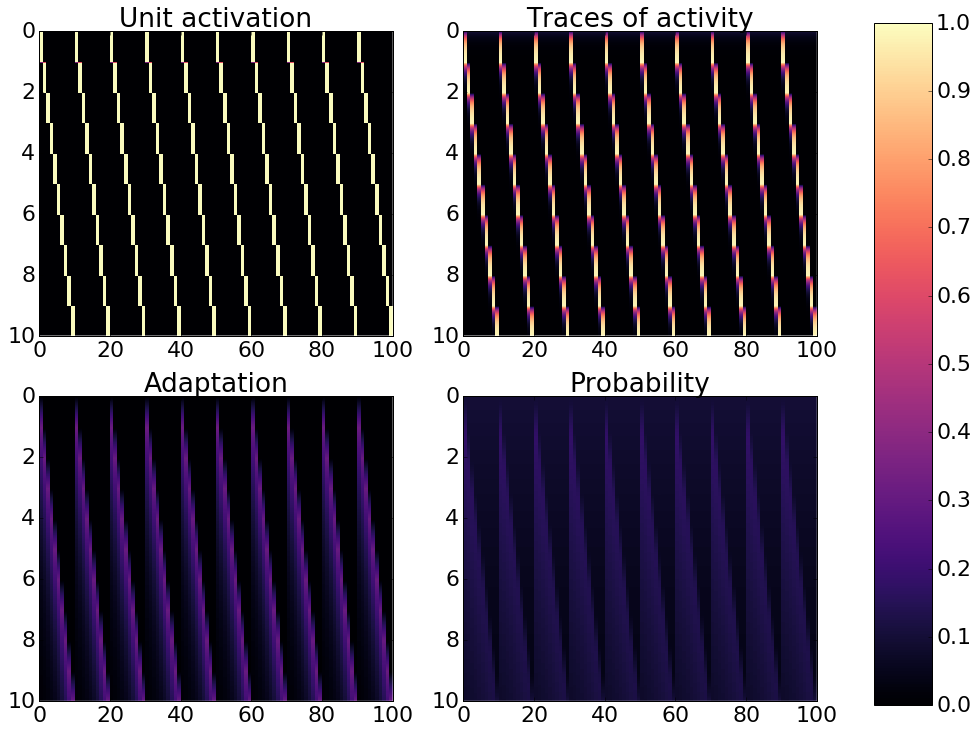

In [6]:
cmap = 'magma'
extent = [0, minicolumns * hypercolumns, aux_counter * T_training, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(o, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(z_pre, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(adaptation, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(p_pre, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

In [7]:
print('Final probability', nn.p_pre)

Final probability [ 0.07840722  0.08161227  0.08622113  0.09133589  0.09698614  0.10323536
  0.11014114  0.11776764  0.1257929   0.1085003   0.07839976  0.08161488
  0.08622146  0.09133368  0.09698872  0.10323498  0.11014276  0.11776807
  0.12579589  0.10849981  0.07840974  0.08161318  0.08622197  0.09133477
  0.0969868   0.10323549  0.110139    0.11776665  0.12579453  0.10849788
  0.07840809  0.08161306  0.08621899  0.0913336   0.09698758  0.1032357
  0.11014135  0.11776825  0.12579478  0.1084986   0.07840876  0.08161236
  0.08621971  0.09133497  0.09698757  0.10323529  0.11013924  0.11776821
  0.12579417  0.10849972  0.07838881  0.08161833  0.08621988  0.09133748
  0.09698631  0.10324029  0.1101457   0.11777032  0.1257955   0.10849738
  0.07840755  0.08161293  0.08622104  0.0913355   0.09698873  0.10323633
  0.11013897  0.11776683  0.12579471  0.10849741  0.07840935  0.08161154
  0.08621943  0.09133245  0.09698923  0.1032344   0.11014074  0.11777025
  0.12579567  0.10849694  0.078388

#### Plot the final weight matrix
Here we plot how the weight matrix looks at the end of every learning step. That is, after the network has been running clamped to a particular pattern for T_training time.

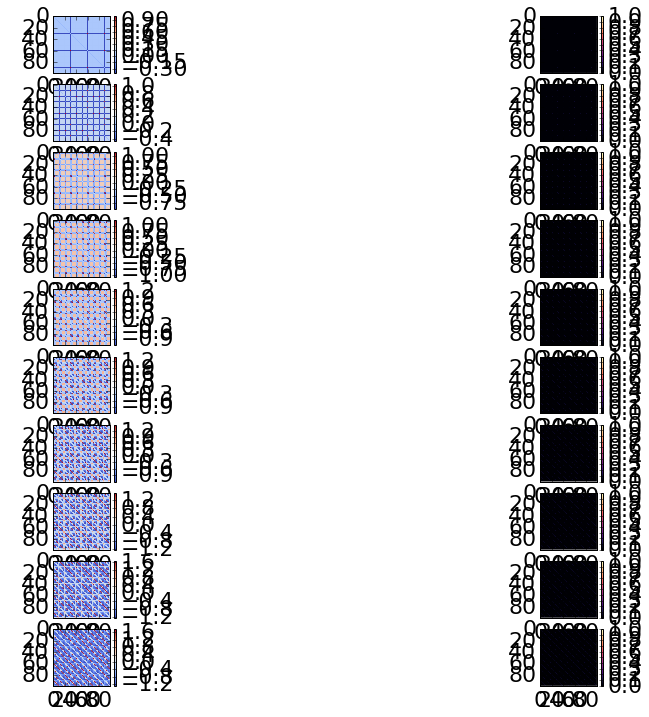

In [8]:
cmap1 = 'coolwarm'
cmap2 = 'magma'

gs = gridspec.GridSpec(aux_counter, 2)
fig = plt.figure(figsize=(16, 12))

for index, (w, p_co) in enumerate(zip(w_end, p_co_end)):

    ax = fig.add_subplot(gs[index, 0])
    im = ax.imshow(w, cmap=cmap1, interpolation='None')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)
    
    ax = fig.add_subplot(gs[index, 1])
    im = ax.imshow(p_co, cmap=cmap2, interpolation='None', vmin=0, vmax=1)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, ax=ax, cax=cax)

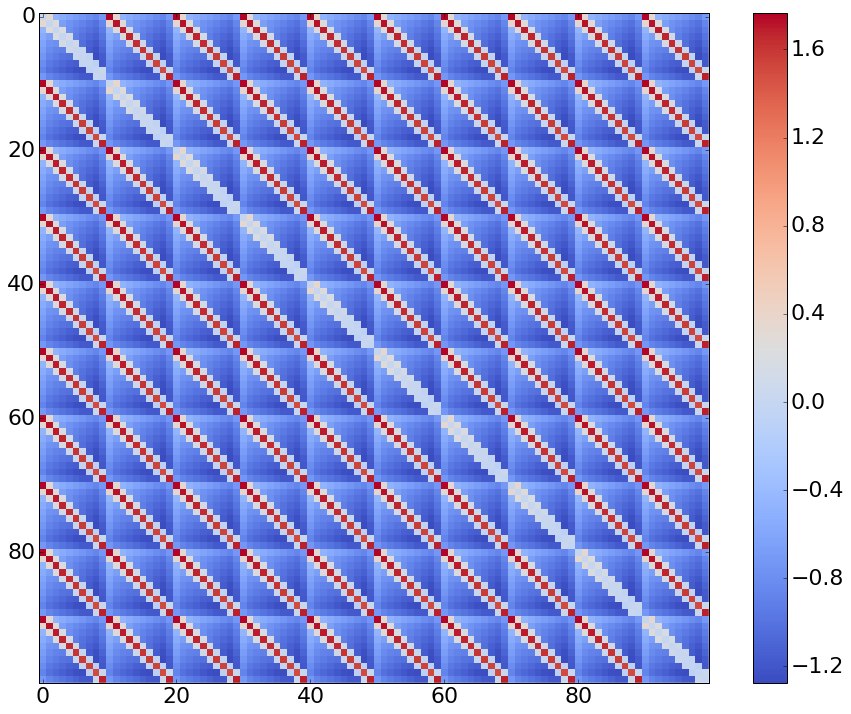

In [9]:
fig = plt.figure(figsize=(16, 12))
plt.imshow(w, cmap=cmap1, interpolation='None')
plt.colorbar()

#### Ideal w and P
We plot the ideal versions of w and P (not trained in time) for reference

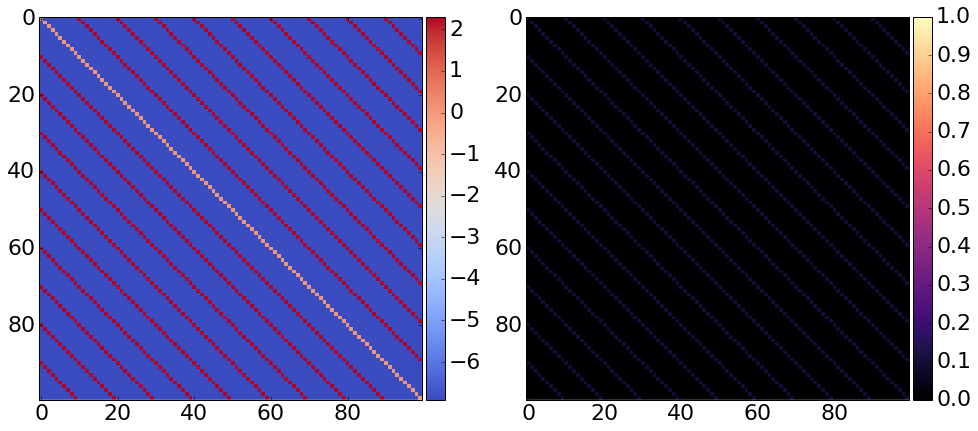

In [10]:
cmap1 = 'coolwarm'
cmap2 = 'magma'

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(w_ideal, cmap=cmap1, interpolation='None')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, ax=ax, cax=cax)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(P_ideal, cmap=cmap2, interpolation='None', vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, ax=ax, cax=cax)

#### Convergence of w and p_co
Here we plot the difference between w and p_co and their ideal versions (not trained in time). 

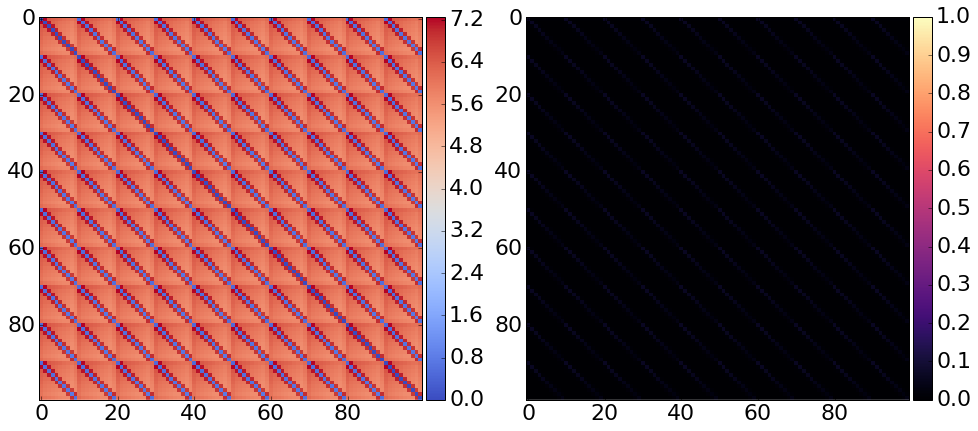

In [11]:
cmap1 = 'coolwarm'
cmap2 = 'magma'

gs = gridspec.GridSpec(1, 2)
fig = plt.figure(figsize=(16, 12))

ax = fig.add_subplot(gs[0, 0])
im = ax.imshow(distance_w, cmap=cmap1, interpolation='None')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, ax=ax, cax=cax)

ax = fig.add_subplot(gs[0, 1])
im = ax.imshow(distance_P, cmap=cmap2, interpolation='None', vmin=0, vmax=1)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, ax=ax, cax=cax)

## Retrieval
Now that we have trained our weights we can see what happen when we retrieve patterns from it for a long time.

In [12]:
T_retrieval = 30.0
retrieval_time = np.arange(0, T_retrieval + dt, dt)

# First empty the history
nn.empty_history()
nn.reset_values(keep_connectivity=True)
# Run in retrival mode
nn.randomize_pattern()
nn.k = 0
nn.g_a = 97.0
nn.run_network_simulation(retrieval_time, I=None, save=True)

o = nn.history['o']
s = nn.history['s']
z_pre = nn.history['z_pre']
p_pre = nn.history['p_pre']

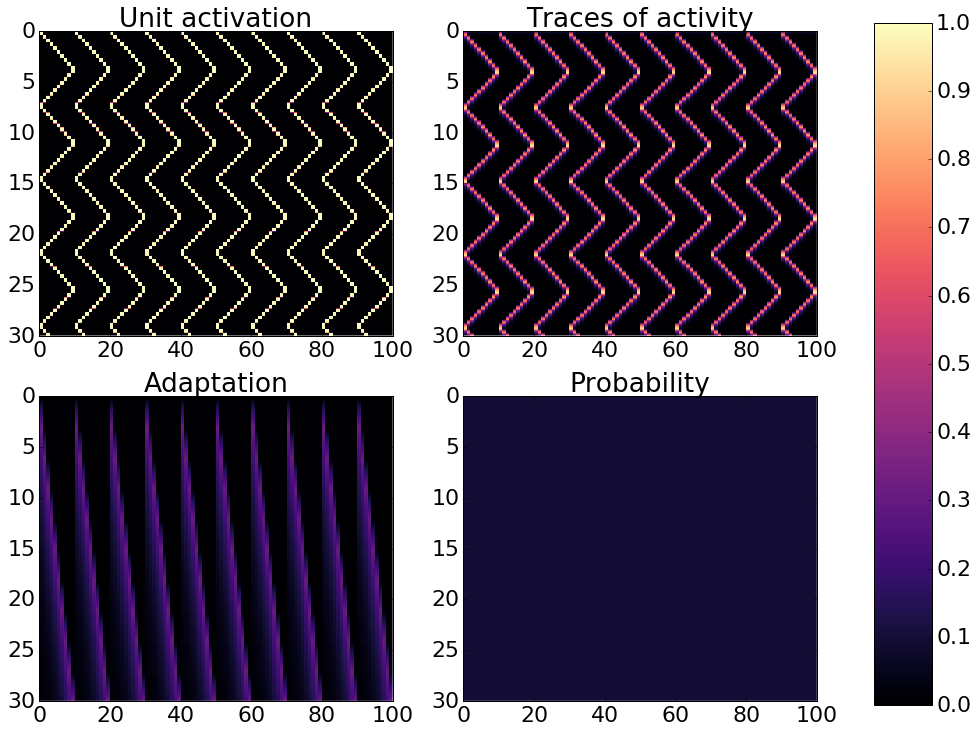

In [13]:
cmap = 'magma'
extent = [0, minicolumns * hypercolumns, T_retrieval, 0]

fig = plt.figure(figsize=(16, 12))

ax1 = fig.add_subplot(221)
im1 = ax1.imshow(o, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax1.set_title('Unit activation')

ax2 = fig.add_subplot(222)
im2 = ax2.imshow(z_pre, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax2.set_title('Traces of activity')

ax3 = fig.add_subplot(223)
im3 = ax3.imshow(adaptation, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax3.set_title('Adaptation')

ax4 = fig.add_subplot(224)
im4 = ax4.imshow(p_pre, aspect='auto', interpolation='None', cmap=cmap, vmax=1, vmin=0, extent=extent)
ax4.set_title('Probability')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.12, 0.05, 0.79])
fig.colorbar(im1, cax=cbar_ax)

In [14]:
print(nn.history['o'].shape)
print(nn.g_a)
print(nn.o)

(30001, 100)
97.0
[  5.72663210e-10   2.28545863e-07   9.83438413e-01   1.65556545e-02
   1.46136472e-06   9.26126448e-07   7.16133438e-07   4.93023549e-07
   3.06729911e-07   1.80006684e-06   5.72824885e-10   2.28507487e-07
   9.83435696e-01   1.65583707e-02   1.46169773e-06   9.26177733e-07
   7.16268007e-07   4.93076748e-07   3.06820336e-07   1.80017319e-06
   5.72743674e-10   2.28539667e-07   9.83436693e-01   1.65573743e-02
   1.46151731e-06   9.26199579e-07   7.16091230e-07   4.93027153e-07
   3.06787425e-07   1.79994536e-06   5.72647980e-10   2.28508591e-07
   9.83438578e-01   1.65554898e-02   1.46133731e-06   9.26046514e-07
   7.16069228e-07   4.92991998e-07   3.06740116e-07   1.79971691e-06
   5.72628120e-10   2.28528421e-07   9.83439110e-01   1.65549583e-02
   1.46136175e-06   9.26052384e-07   7.15995824e-07   4.93005081e-07
   3.06732939e-07   1.79986595e-06   5.72996556e-10   2.28438486e-07
   9.83437214e-01   1.65568530e-02   1.46153523e-06   9.26491278e-07
   7.16408125e-0

In [15]:
n_trials = 10
final_patterns = []
for i in range(n_trials):
    nn.randomize_pattern()
    nn.k = 0
    nn.run_network_simulation(retrieval_time)
    final_patterns.append(nn.o)

In [16]:
final_patterns

[array([  2.04365699e-10,   7.93136003e-07,   9.99966757e-01,
          3.20732750e-05,   7.93297502e-08,   6.08131891e-08,
          4.86547184e-08,   3.42179908e-08,   2.15257689e-08,
          1.31583576e-07,   2.04459915e-10,   7.92983965e-07,
          9.99966755e-01,   3.20759421e-05,   7.93504191e-08,
          6.08165882e-08,   4.86647601e-08,   3.42219475e-08,
          2.15327434e-08,   1.31591442e-07,   2.04383107e-10,
          7.93102693e-07,   9.99966756e-01,   3.20750447e-05,
          7.93382606e-08,   6.08178138e-08,   4.86507843e-08,
          3.42178186e-08,   2.15300024e-08,   1.31571515e-07,
          2.04362321e-10,   7.93023885e-07,   9.99966760e-01,
          3.20710166e-05,   7.93315372e-08,   6.08096134e-08,
          4.86516339e-08,   3.42167913e-08,   2.15273340e-08,
          1.31559319e-07,   2.04349589e-10,   7.93089386e-07,
          9.99966759e-01,   3.20713060e-05,   7.93320366e-08,
          6.08092442e-08,   4.86453627e-08,   3.42174140e-08,
        

#### Git recover
Here we checkout the latest working branch again

In [17]:
if run_old_version:
    subprocess.call(['git', 'checkout', 'master'])

NameError: name 'run_old_version' is not defined